Deep Dream Implementation 

In [0]:
!pip install tensorflow-gpu==2.0.0.alpha0

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

1) Import the model

In [3]:
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')
base_model.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_v1[0][0]     
______________________

In [0]:
# Take the concatenated layers from inception
names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']

# Get the layers output
layers = [base_model.get_layer(name).output for name in names]

# Model definition with functional API
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


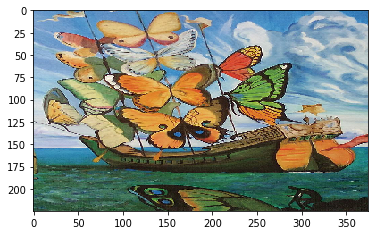

In [5]:
from google.colab import drive
drive.mount('/content/drive')

sample_image = tf.keras.preprocessing.image.load_img(
    r'/content/drive/My Drive/Colab Notebooks/salvador_dali.jpg', 
    target_size = (225, 375))

plt.imshow(sample_image)

In [6]:
sample_image = np.array(sample_image)/255
sample_image.shape

(225, 375, 3)

2) Run the model

In [7]:
sample_array = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_array.shape


(225, 375, 3)

In [8]:
sample_variable = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_array))
sample_variable = tf.expand_dims(sample_variable, axis = 0)
np.shape(sample_variable)

TensorShape([1, 225, 375, 3])

In [0]:
# Visualize the activation layers
activations = deepdream_model(sample_variable)

3) Network loss calculation

In [0]:
def calc_loss(image, model):
  
  # Expand dimension of the image
  img_batch = tf.expand_dims(image, axis=0)

  # Run the model  
  layer_activations = model(img_batch)

  # Calculate the losses
  losses = []

  for act in layer_activations:
    loss = tf.math.reduce_mean(act) # calculate mean of each activation 
    losses.append(loss)
  
  print('LOSSES (FROM MULTIPLE ACTIVATION LAYERS) = ', losses)
  print('LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) = ', np.shape(losses))
  print('SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)= ', tf.reduce_sum(losses))
  
  # Calculate sum
  return  tf.reduce_sum(losses)  



In [11]:
sample_image = tf.keras.preprocessing.image.load_img(
    r'/content/drive/My Drive/Colab Notebooks/salvador_dali.jpg', 
    target_size = (225, 375))

sample_image = np.array(sample_image)/255

sample_array = tf.keras.preprocessing.image.img_to_array(sample_image)

sample_variable = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_array))

# Sum of 4 loss of the previous selected layers
overall_loss = calc_loss(sample_variable, deepdream_model)

LOSSES (FROM MULTIPLE ACTIVATION LAYERS) =  [<tf.Tensor: id=13085, shape=(), dtype=float32, numpy=0.2716141>, <tf.Tensor: id=13087, shape=(), dtype=float32, numpy=0.16908208>, <tf.Tensor: id=13089, shape=(), dtype=float32, numpy=0.14528689>, <tf.Tensor: id=13091, shape=(), dtype=float32, numpy=0.051277325>]
LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) =  (4,)
SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)=  tf.Tensor(0.6372604, shape=(), dtype=float32)


4) Gradient calculation from the previous losses

In [0]:
@tf.function
def deepdream(model, image, step_size):
    # Track the specific gradients
    with tf.GradientTape() as tape:
      tape.watch(image)

      # Calculate the loss of the glayers
      loss = calc_loss(image, model) 

    # Gradient calculation
    gradients = tape.gradient(loss, image)

    print('GRADIENTS =\n', gradients)
    print('GRADIENTS SHAPE =\n', np.shape(gradients))

    # Standard deviation of all the gradients
    gradients /= tf.math.reduce_std(gradients)  

    # Add the gradients to the image and clip the values
    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)

    return loss, image

In [0]:
def process(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)

In [0]:

def run_deep_dream(model, image, steps = 100, step_size = 0.01):

  # Preprocess input
  image = tf.keras.applications.inception_v3.preprocess_input(image)

  # Calculate for different step sizes
  for step in range(steps):
    loss, image = deepdream(model, image, step_size)

    # Print figures
    if step % 100 == 0:
      plt.figure(figsize = (12, 12))
      plt.imshow(process(image))
      plt.show()
      print ("Step {}, loss {}".format(step, loss))

  plt.figure(figsize=(12,12))
  plt.imshow(process(image))
  plt.show()

  return process(image)


5) Check the results

LOSSES (FROM MULTIPLE ACTIVATION LAYERS) =  [<tf.Tensor 'Mean:0' shape=() dtype=float32>, <tf.Tensor 'Mean_1:0' shape=() dtype=float32>, <tf.Tensor 'Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'Mean_3:0' shape=() dtype=float32>]
LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) =  (4,)
SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)=  Tensor("Sum:0", shape=(), dtype=float32)
GRADIENTS =
 Tensor("Reshape_5:0", shape=(225, 275, 3), dtype=float32)
GRADIENTS SHAPE =
 (225, 275, 3)


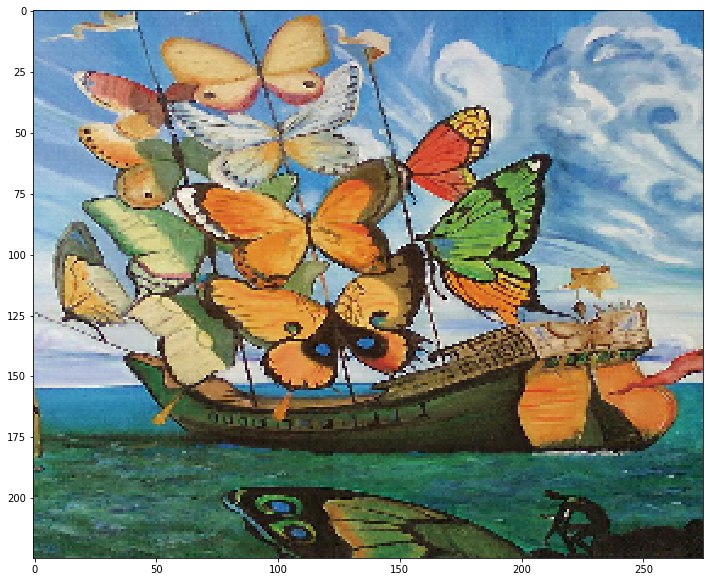

Step 0, loss 0.9905524849891663


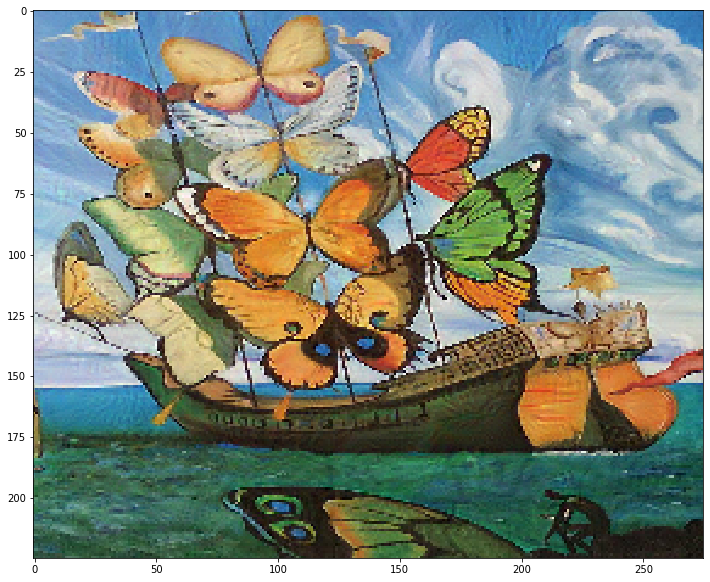

Step 100, loss 1.9267559051513672


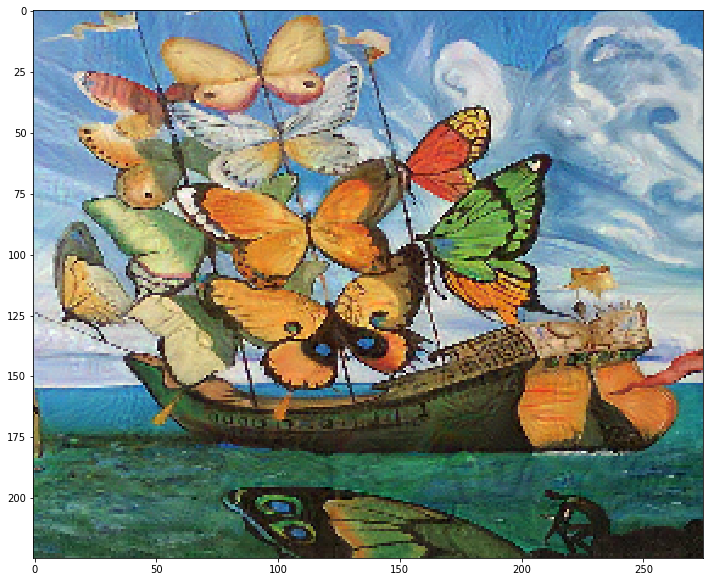

Step 200, loss 2.2167739868164062


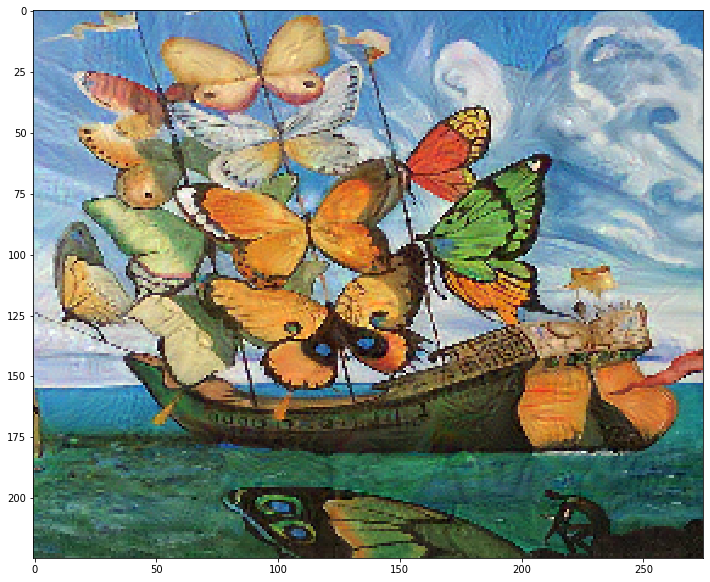

Step 300, loss 2.410667896270752


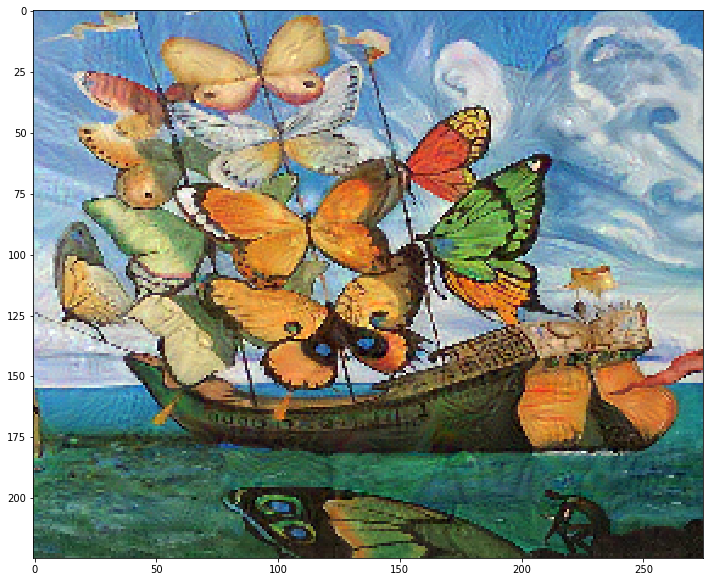

Step 400, loss 2.5573549270629883


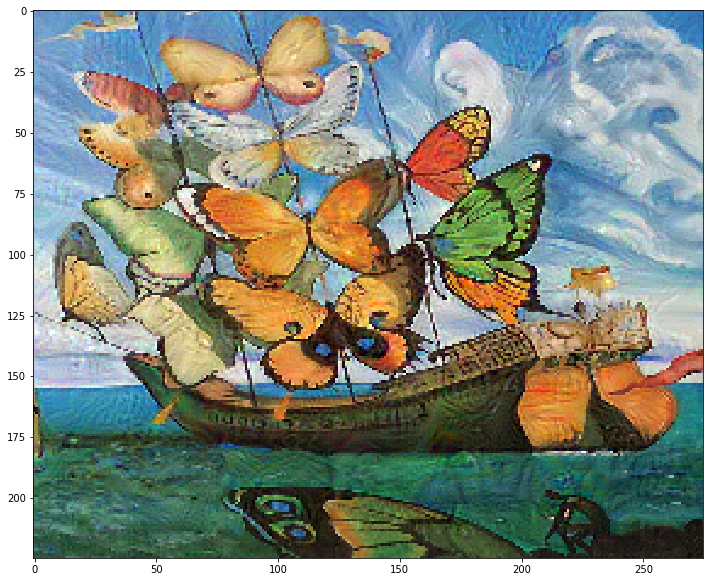

Step 500, loss 2.6648764610290527


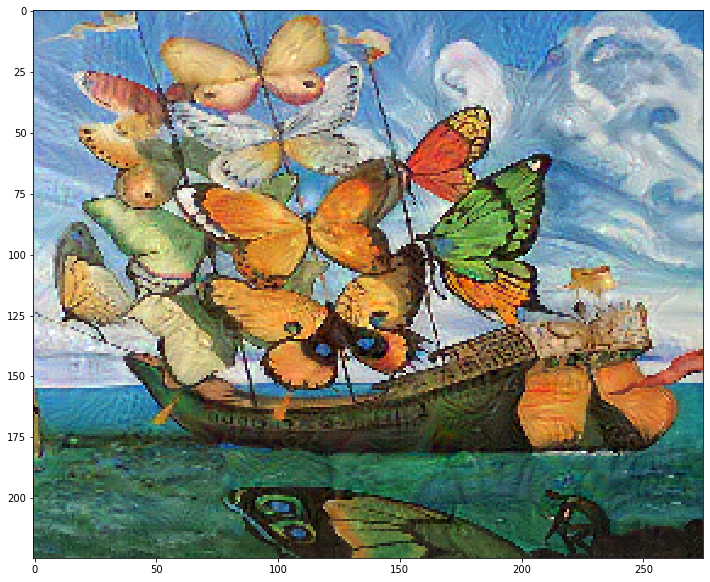

Step 600, loss 2.7613043785095215


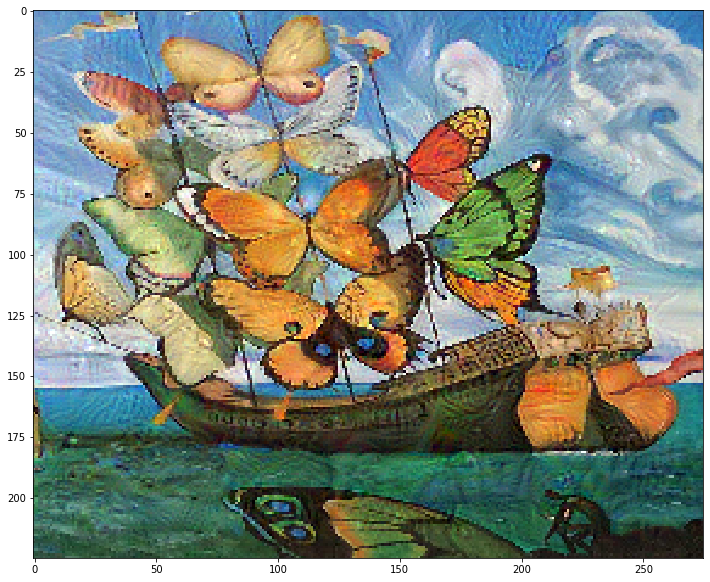

Step 700, loss 2.8421530723571777


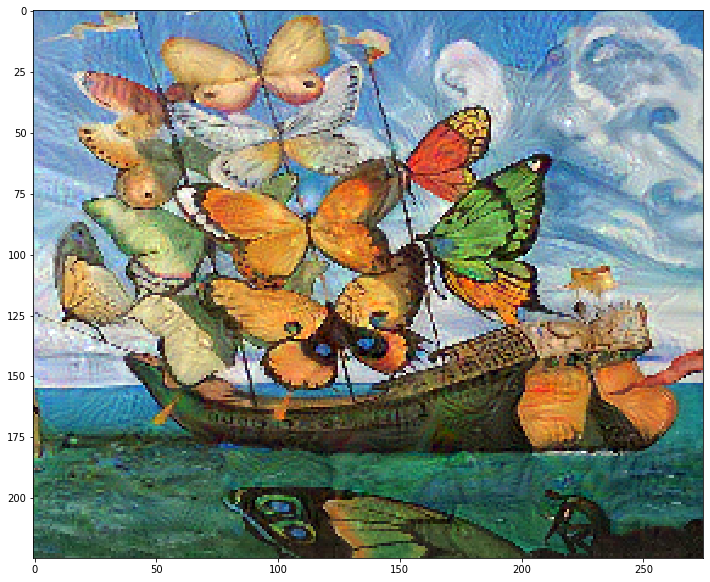

Step 800, loss 2.912966728210449


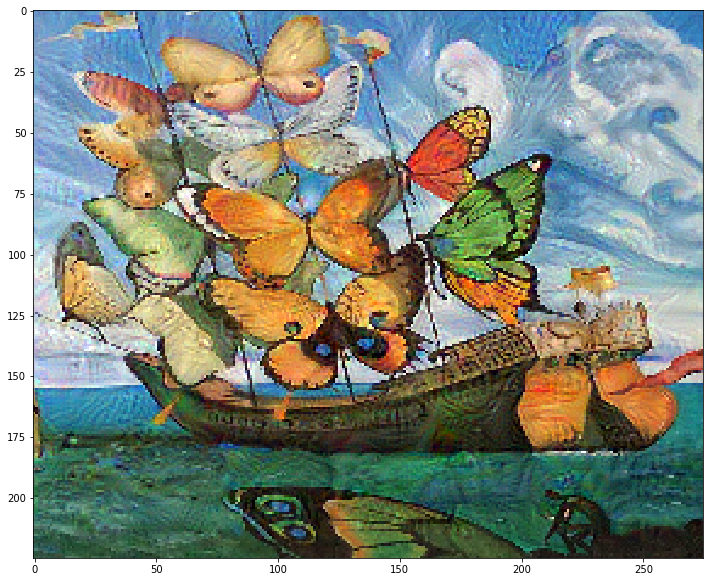

Step 900, loss 2.9693074226379395


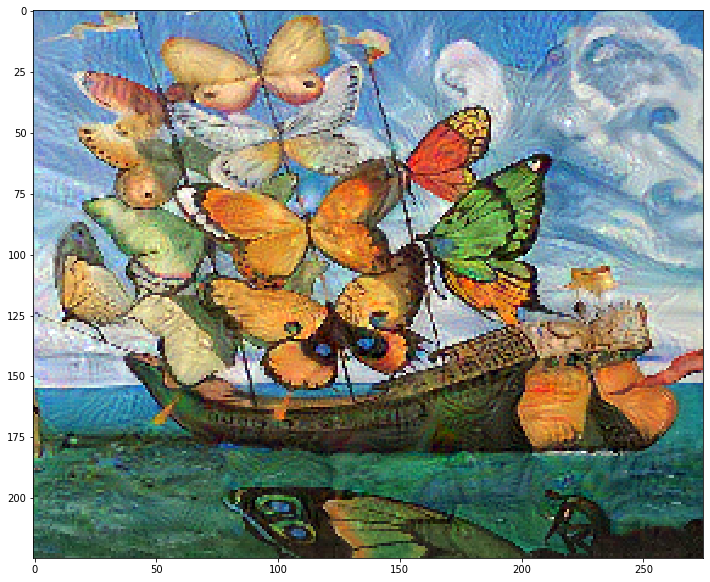

Step 1000, loss 3.0182390213012695


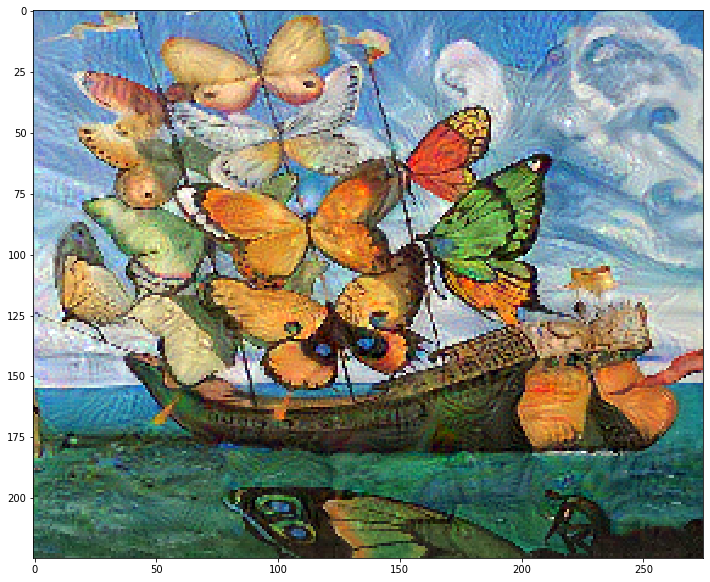

Step 1100, loss 3.066948652267456


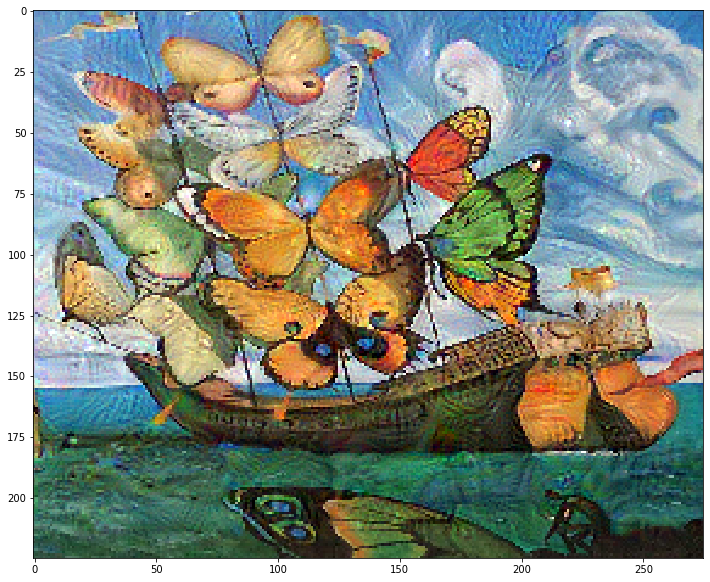

Step 1200, loss 3.1077356338500977


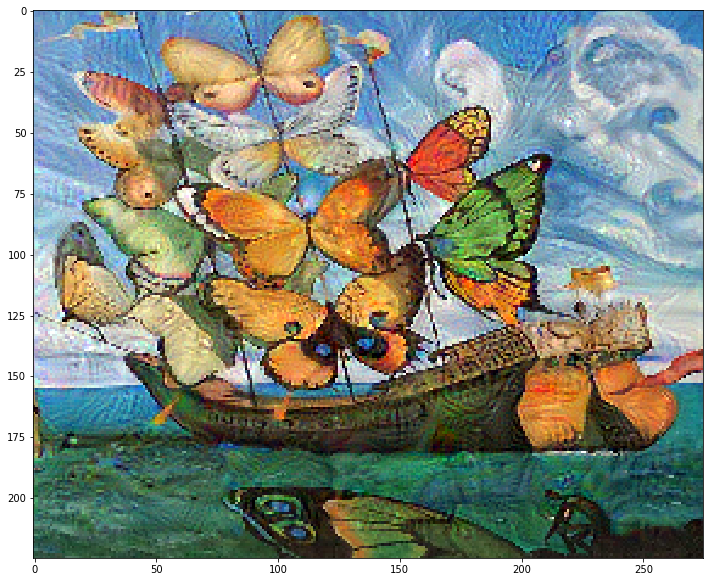

Step 1300, loss 3.1459946632385254


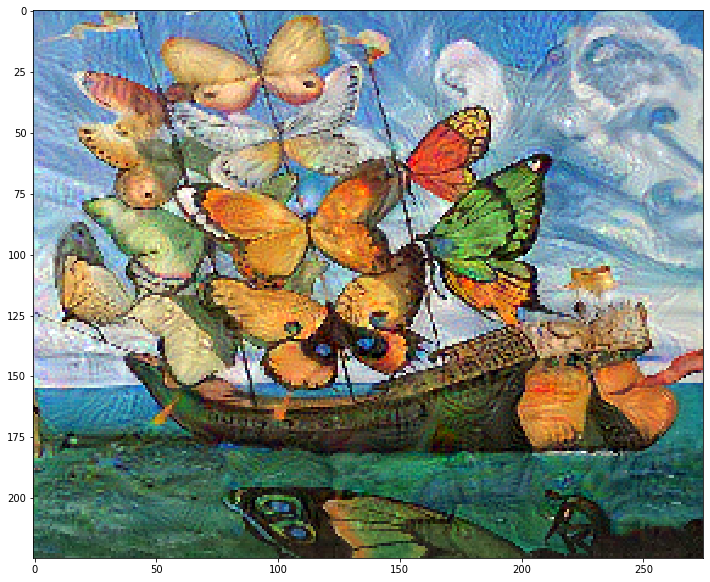

Step 1400, loss 3.1841049194335938


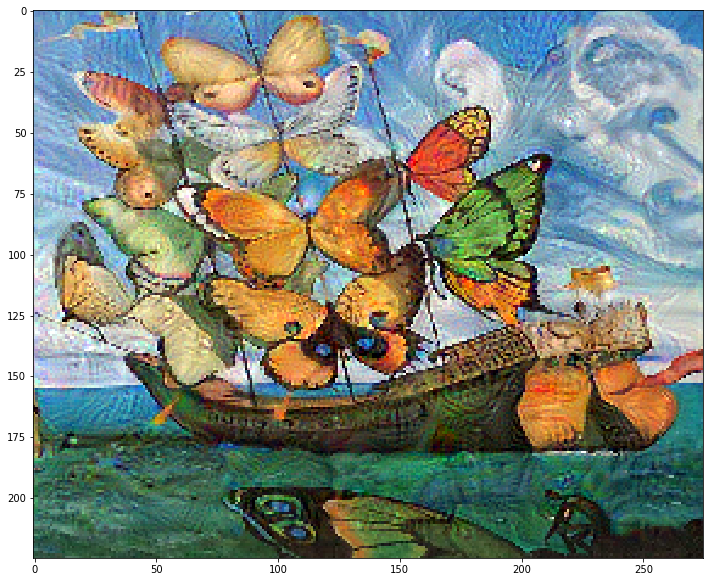

Step 1500, loss 3.2188925743103027


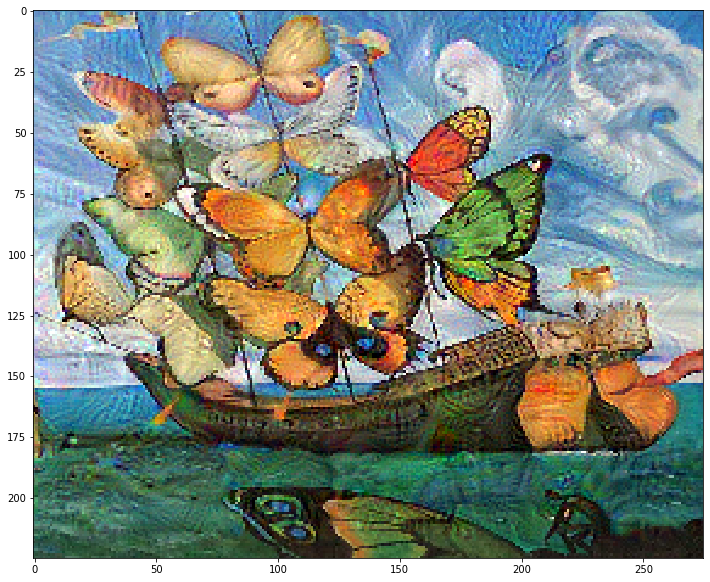

Step 1600, loss 3.25299072265625


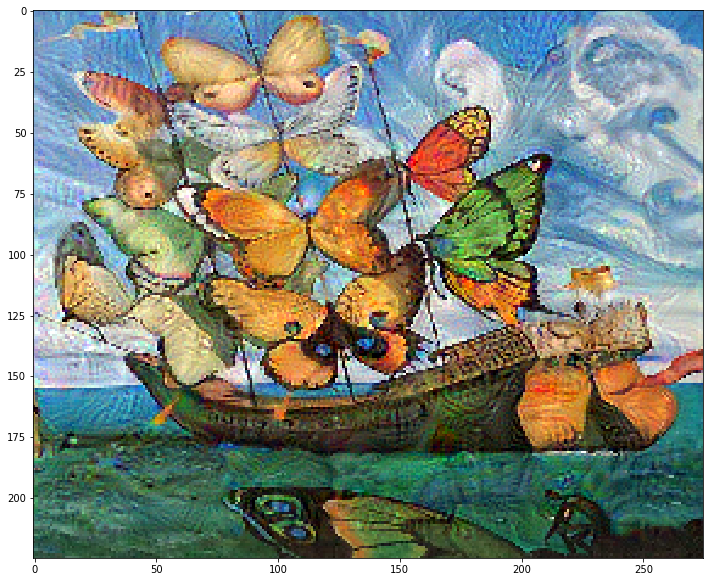

Step 1700, loss 3.283583164215088


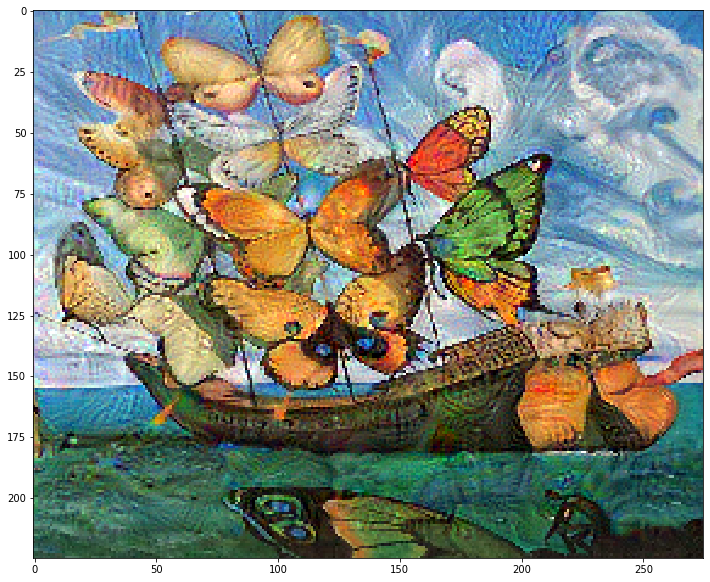

Step 1800, loss 3.3134353160858154


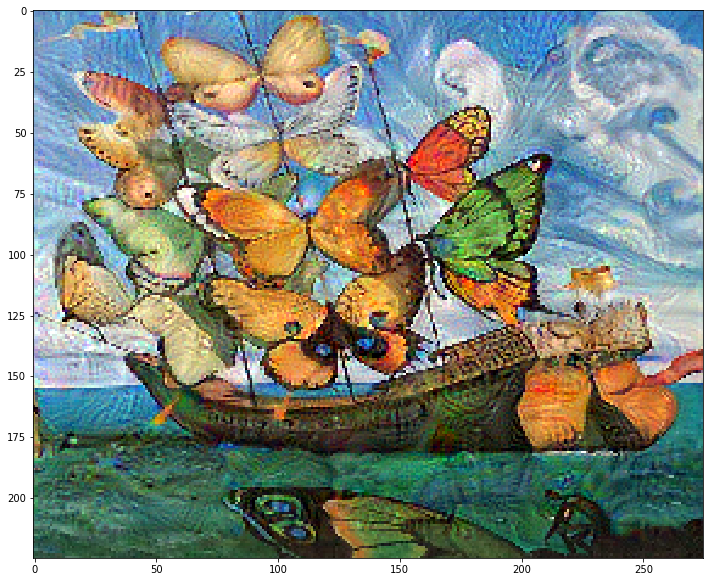

Step 1900, loss 3.341339349746704


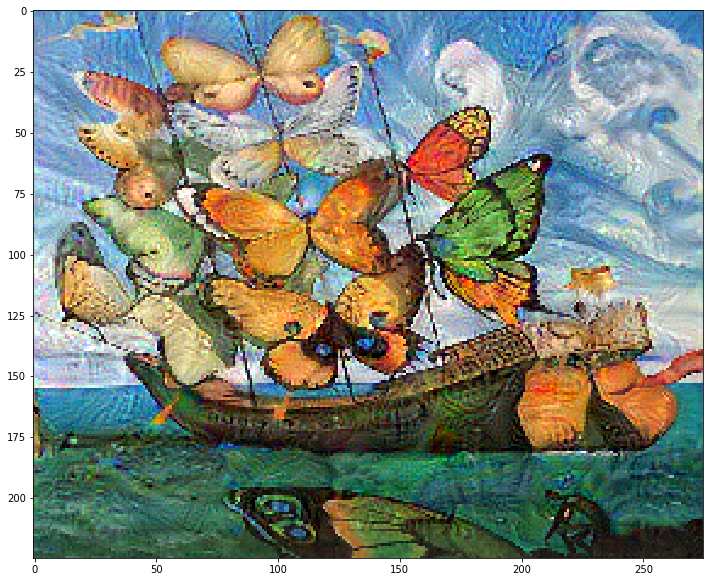

In [17]:

sample_image= tf.keras.preprocessing.image.load_img(
    r'/content/drive/My Drive/Colab Notebooks/salvador_dali.jpg', 
    target_size = (225, 275))

sample_image = np.array(sample_image)

dream_img = run_deep_dream(model = deepdream_model, 
                           image = sample_image, 
                           steps = 2000,
                           step_size = 0.001)
